# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

The product manager for recipe discovery has reached out and wants us to build a predictive model that correctly predicts high traffic recipes 80% of the time. Some data has been provided for recipes, containing a few features along with whether or not each recipe generates high traffic. The purpose of this is to choose recipes to display on their website that increase the number of visitors to the site, as more visitors leads to more paid subscriptions. 

First the data will need preprocessed, so I will examine each column for reliability: do the numbers make sense, are there missing values, and are there duplicate observations. I will also explore the data a little and do some preliminary analysis to get a better sense of distributions and relationships. I will need to try out a couple predictive models and compare them using a metric that I will decide upon later - likely precision, given the business task and requirement. After choosing my preferred model, I will test it on previously-unseen data to determine how it is likely to perform on real-life data. Finally, I will discuss the model's expected impact on real-life business metrics and how the company might measure success, making some recommendations alongside implementation of the predictive model.

# Preprocessing

I will examine the data by looking at column information and quick statistics, looking for missing values and duplicate rows, cleaning the data as needed.

In [3]:
# read csv into dataframe
df = pd.read_csv('recipe_site_traffic_2212.csv')

In [4]:
# inspect dataframe
df.info()
display(df.describe(include='all'))
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
count,947.000000,895.000000,895.000000,895.000000,895.000000,947,947,574
unique,NaN,NaN,NaN,NaN,NaN,11,6,1
top,NaN,NaN,NaN,NaN,NaN,Breakfast,4,High
freq,NaN,NaN,NaN,NaN,NaN,106,389,574
mean,474.000000,435.939196,35.069676,9.046547,24.149296,NaN,NaN,NaN
std,273.519652,453.020997,43.949032,14.679176,36.369739,NaN,NaN,NaN
min,1.000000,0.140000,0.030000,0.010000,0.000000,NaN,NaN,NaN
25%,237.500000,110.430000,8.375000,1.690000,3.195000,NaN,NaN,NaN
50%,474.000000,288.550000,21.480000,4.550000,10.800000,NaN,NaN,NaN
75%,710.500000,597.650000,44.965000,9.800000,30.200000,NaN,NaN,NaN


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


high_traffic indicates the target variable. We want to classify each observation based on this column. 

recipe is the unique identifier. 

calories, carbs, sugar, protein, category, and servings will be features.

cals, carbs, sugar, protein are missing the same number of values - I wonder if these missing values will correlate with each other.

A number of the observations seem to be missing a target...I will investigate this further.

Datatypes are very reasonable, except for servings, which I wille examine later. With a larger dataset, I would round the floats to the nearest integer, so I'll do that here in case the preprocessing needs scaled up.

In [5]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 66.6+ KB


No observations have been dropped as duplicates.

I first look at recipe. The calories go up to pretty high values, let's look at those.

In [6]:
df[df.calories > 2000]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
55,56,2122.24,25.99,0.52,81.37,Pork,1,High
71,72,2508.47,18.11,10.60,84.23,Chicken,4,NaN
97,98,2081.69,8.09,4.78,28.48,One Dish Meal,2,High
124,125,2906.01,3.52,1.89,179.22,Pork,6,High
226,227,2703.12,6.40,2.17,28.20,Pork,6,High
356,357,2282.60,4.50,4.16,31.19,One Dish Meal,4,High
397,398,2051.34,2.46,2.12,69.62,Chicken,2,High
636,637,2029.33,25.08,0.61,54.00,One Dish Meal,1,High
781,782,2068.07,34.23,1.46,10.02,Potato,1,High
907,908,2332.32,7.47,3.62,34.33,One Dish Meal,1,High


There are a dozen meals with calories over 2000, but only a couple of them are six servings. It is incorrect that a 2000 calorie meal can be one serving, but really this just reflects on the reliability of the servings feature. I will leave these in, as removing these would necessitate a further investigation into data that is essentially intact aside from these minor points.

In [7]:
print(df.recipe.duplicated().sum())

0


Recipe looks good. Onto calories, carbs, sugar, and protein - let's see if certain observations are missing all of these features, and check out the max values to see if they make sense.

In [8]:
df[df.calories.isna()]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,NaN
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,NaN
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken Breast,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


There are 52 missing values in these features, and we see that the missing features are indeed found in the same observations. I wonder what this ratio is:

In [9]:
print(df.calories.isna().sum()/df.shape[0])

0.054910242872228086


Although only 5.5% of the data would be dropped, it is easy enough to impute the missing values with their respective medians. Let's then change datatypes.

In [10]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
columns = ['calories', 'carbohydrate', 'sugar', 'protein']
df[columns] = imputer.fit_transform(df[columns])
df[columns] = df[columns].round().astype('int16')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   recipe        947 non-null    int64 
 1   calories      947 non-null    int16 
 2   carbohydrate  947 non-null    int16 
 3   sugar         947 non-null    int16 
 4   protein       947 non-null    int16 
 5   category      947 non-null    object
 6   servings      947 non-null    object
 7   high_traffic  574 non-null    object
dtypes: int16(4), int64(1), object(3)
memory usage: 44.4+ KB


Let's check out the category feature.

In [11]:
print(df.category.value_counts())

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


The categories are reasonable, as are the numbers for each of them. Breakfast is the most popular, with one dish meals being least popular, but the range isn't too great. I wonder what the general "meat" indicates considering that chicken and pork are included. I could combine chicken and chicken breast into one category, but the general "chicken" category may apply to thighs, wings, etc.

Looking at servings...

In [12]:
df.servings.value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [13]:
df[df.servings=='4 as a snack']

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
451,452,1543,15,6,30,Lunch/Snacks,4 as a snack,High
735,736,514,66,19,18,Lunch/Snacks,4 as a snack,NaN


In [14]:
df[df.servings=='6 as a snack']

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
548,549,1441,31,6,31,Lunch/Snacks,6 as a snack,High


In [15]:
# Let's roll '4 as a snack' into just 4, and so on
df.loc[[451, 735], 'servings'] = 4
df.loc[548, 'servings'] = 6

In [16]:
df.servings = pd.to_numeric(df.servings).astype('int8')

In [17]:
df.servings.value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

Verified this success. Onto the target.

In [18]:
df.high_traffic.value_counts()

High    574
Name: high_traffic, dtype: int64

Thankfully, missing values simply seem to indicate a low traffic rate. We can fix this.

In [19]:
df.high_traffic.fillna('Low', inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   recipe        947 non-null    int64 
 1   calories      947 non-null    int16 
 2   carbohydrate  947 non-null    int16 
 3   sugar         947 non-null    int16 
 4   protein       947 non-null    int16 
 5   category      947 non-null    object
 6   servings      947 non-null    int8  
 7   high_traffic  947 non-null    object
dtypes: int16(4), int64(1), int8(1), object(2)
memory usage: 70.2+ KB


I am satisfied with the preprocessing.

# EDA

I will explore the data in greater detail, examining class balance for the target, and looking at features I suspect to be of importance for predictions, comparing these features with the target.

I want to look at the distribution of the target, high_traffic, to identify any class imbalance issues.

Text(0.5, 1.0, 'Traffic Distribution')

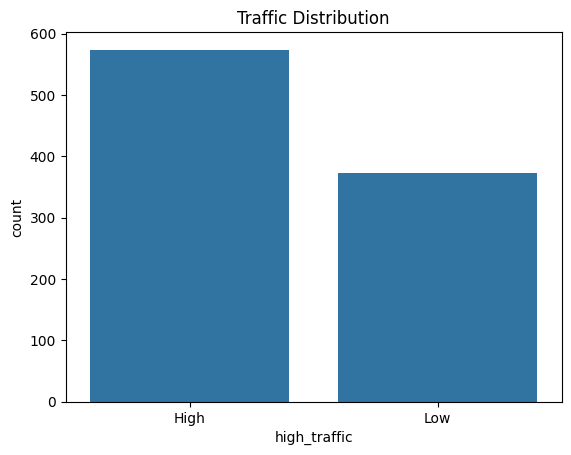

In [21]:
sns.countplot(data=df, x='high_traffic')
df.high_traffic.value_counts(normalize=True)
plt.title('Traffic Distribution')

High traffic composes 61% of the overall observations while low traffic composes 39% of them. I will end up upsampling the low traffic observations a bit to compensate, or using a built-in tool to balance the classes.

Taking a look at the distribution of total calories in meals.

Text(0, 0.5, 'Count')

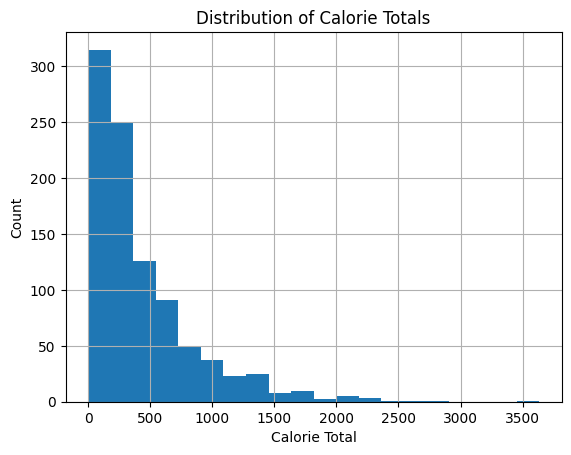

In [22]:
df.calories.hist(bins=20)
plt.title('Distribution of Calorie Totals')
plt.xlabel('Calorie Total')
plt.ylabel('Count')

Most meals are less than 500 calories. Very few are greater than 2000 calories.

I want to look at the relationship between calories and traffic to see if the magnitude of the meal correlates with the popularity.

Text(0.5, 1.0, 'Traffic vs Calorie Totals')

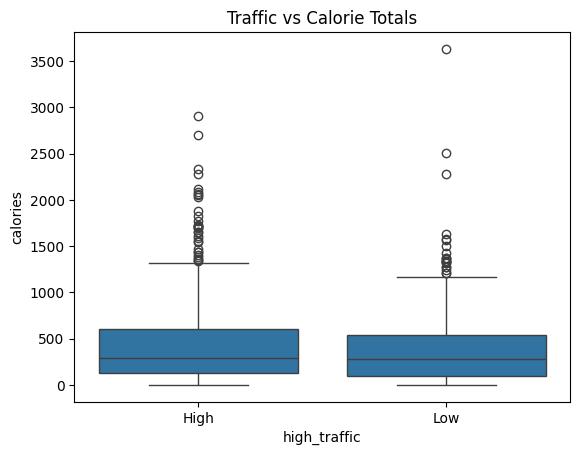

In [23]:
sns.boxplot(data=df, x='high_traffic', y='calories')
plt.title('Traffic vs Calorie Totals')

Caloric value does not seem to affect the traffic received, with medians and spreads that look about equivalent. However, the quartiles and outliers do appear to be slightly higher for high-traffic recipes.

Text(0.5, 1.0, 'Traffic vs Categories')

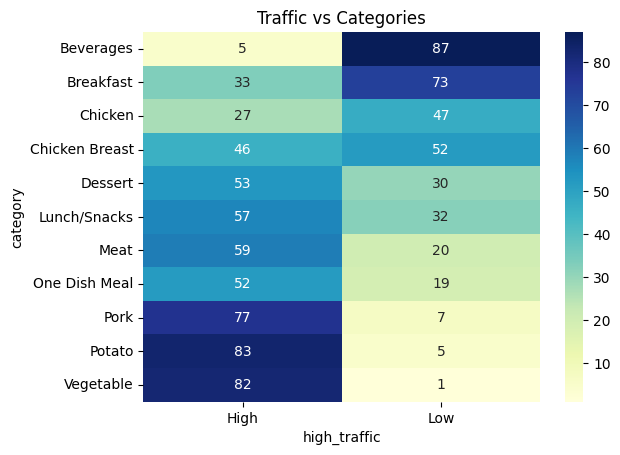

In [24]:
from scipy.stats import chisquare

contingency = pd.crosstab(df.category, df.high_traffic)

sns.heatmap(contingency, annot=True, cmap="YlGnBu")

plt.title('Traffic vs Categories')

The first thing I notice about the heatmap is that there are no cases where the traffic is both low and high for any category, which indicates our data is valid. Our highest traffic items include pork, potato, and vegetable, and our lowest traffic items include beverages and breakfast. This will be valuable information for the company, even without the machine learning predictive component of the project.

# Model Development

This is a classification problem. As such, I will train a quick logistic regression model, and I will also train a random forest classifier model. I will first use a dummy classifier to use as a baseline, and compare accuracies between this score and the trained models. I am choosing a logistic regression model because it will train quickly and offer decent results with little hyperparameter-tuning. I am also using a random forest model to capture more complex feature interactions, though this will take longer to train, hyperparameter-tune, and is more prone to overfitting, which I will have to address through regularization parameters. I will cross-validate each model to ensure more reliable validation scores.

I care more about precision than recall - the company wants its headline meals to be high traffic meals, but we don't necessarily need to find every possible high traffic meal. Also, the company is more interested in true positives - we want to identify the high traffic meals to increase traffic, but a low traffic meal is not hurting the company aside from opportunity cost. The company desires a model than can correctly predict high traffic recipes 80% of the time, which means they desire a model with a precision of 80% or higher. The data is imbalanced, but not heavily imbalanced.

We remember that high traffic meals comprise ~60% of the data while low traffic meals comprise ~40%. Because precision is much more important to this business problem than recall, I will primarily judge models based on precision. I will also monitor the F1 score to ensure reasonable overall performance. The F1 score balances precision and recall and focuses on positive cases. I am choosing this score over ROC AUC score, because the ROC AUC score favors a more balanced view of the model's performance, accounting more for true negatives than the f1 score. However, we are not too concerned about the rate of true negatives and are more concerned about the model's performance with the positive class. If the precision scores for the two models are close, but recall is far better for one model, then I will choose this model to ensure best overall performance and minimize the opportunity cost of missing high-traffic recipes.

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [26]:
features = df.drop(['recipe', 'high_traffic'], axis=1)
target = df.high_traffic

## Dummy Model

In [27]:
dummy = DummyClassifier(strategy='most_frequent')

dummy.fit(features, target)
dummy.score(features, target)

0.6061246040126715

The baseline accuracy is 60.6%, so the accuracy of our trained models must exceed this to be stronger than simply guessing. This is the same number as the proportion of positive targets within the larger dataset.

## Logistic Regression

In [28]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0, test_size=0.2, stratify=target)

cats = list(features_train.select_dtypes('object').columns)
nums = list(features_train.select_dtypes(include='number').columns)

col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(), cats),
    ('scaler', StandardScaler(), nums)
])

log_reg_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('model', LogisticRegression(solver='liblinear', random_state=0, class_weight='balanced'))
])

results = cross_validate(log_reg_pipeline, features_train, target_train, return_train_score=True)

print('Avg train score: ', results['train_score'].mean())
print('Avg validated score: ', results['test_score'].mean())

Avg train score:  0.7562769004173144
Avg validated score:  0.7370948065528059


We've built our logistic regression pipeline and quickly examined its untuned accuracy score. The tested accuracy is about 0.13 higher than the dummy's, which is reasonable.

In [29]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

grid = {'model__C': [0.5, 1, 2, 3, 30, 40, 50],
       'model__max_iter': [1750, 3000],
       'model__tol': [0.001, 0.01, 0.1]}

scoring = {'accuracy': 'accuracy',
          'precision': make_scorer(precision_score, pos_label='High'),
          'recall': make_scorer(recall_score, pos_label='High'),
          'f1': make_scorer(f1_score, pos_label='High')}

grid_search_lr = GridSearchCV(estimator=log_reg_pipeline, param_grid=grid, cv=StratifiedKFold(n_splits=4), return_train_score=True, 
                           scoring=scoring, 
                           refit='precision'
                          )
grid_search_lr.fit(features_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(),
                                                                         ['category']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings'])])),
                                       ('model',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=0,
                                                           solver='liblinear'))]),
             param_grid={'model__C': [0.5, 1, 2, 3, 30, 40, 50],
                         'model__max_iter': [1750, 3000],
                         'model__tol': [0.001, 0.01, 0.1]},
             refit='precision', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, pos_label=High),
                      'precision': make_scorer(precision_score, pos_label=High),
                      'recall': make_scorer(recall_score, pos_label=High)})

In [30]:
grid_search_lr.best_params_

{'model__C': 30, 'model__max_iter': 1750, 'model__tol': 0.001}

Below we will check the trained and validated precision scores.

In [31]:
def return_scores(grid_search):
    print('Avg trained precision:', pd.Series(grid_search.cv_results_['mean_train_precision']).mean())
    print('Avg validated precision:', pd.Series(grid_search.cv_results_['mean_test_precision']).mean(), '\n')

    print('Avg trained recall:', pd.Series(grid_search.cv_results_['mean_train_recall']).mean())
    print('Avg validated recall:', pd.Series(grid_search.cv_results_['mean_test_recall']).mean(), '\n')

    print('Avg trained F1 score:', pd.Series(grid_search.cv_results_['mean_train_f1']).mean())
    print('Avg validated F1 score:', pd.Series(grid_search.cv_results_['mean_test_f1']).mean(), '\n')

    print('Avg trained accuracy:', pd.Series(grid_search.cv_results_['mean_train_accuracy']).mean())
    print('Avg validated accuracy:', pd.Series(grid_search.cv_results_['mean_test_accuracy']).mean())

In [32]:
return_scores(grid_search_lr)

Avg trained precision: 0.8318697022508527
Avg validated precision: 0.8259530500953512 

Avg trained recall: 0.7456120500104323
Avg validated recall: 0.7364788783553086 

Avg trained F1 score: 0.7860130004702557
Avg validated F1 score: 0.778232118218669 

Avg trained accuracy: 0.7540441428701544
Avg validated accuracy: 0.7456223230032754


Logistic Regression, when optimized for precision, has resulted in a precision of 82.6% and a recall of 73.6%. This suggests a reasonably high precision (when the model predicts a meal will be high traffic, it is correct 82.6% of the time) but with a decent recall tradeoff (the model only finds about 73.6% of all high_traffic meals, which is acceptable). Although precision is most important, we don't want to neglect too many high traffic recipes for the sake of variety, and surely there are only so many possible recipes in the world. Accuracy at 74.5% is distinctly greater than the 60% class balance. 

Logistic regression is a fairly straightforward model which was quick to train and is quick to predict. We will likely get additional performance from our Random Forest model.

## Random Forest

In [33]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0, test_size=0.2, stratify=target)

cats = list(features_train.select_dtypes('object').columns)
nums = list(features_train.select_dtypes(include='number').columns)

col_transformer = ColumnTransformer(transformers=[
    ('ordinal encoder', OrdinalEncoder(), cats),
    ('scaler', StandardScaler(), nums)
])

rf_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('model', RandomForestClassifier(random_state=0, class_weight='balanced'))
])

results = cross_validate(rf_pipeline, features_train, target_train, return_train_score=True)

print('Avg trained accuracy: ', results['train_score'].mean())
print('Avg validated accuracy: ', results['test_score'].mean())

Avg trained accuracy:  0.9966974879306113
Avg validated accuracy:  0.7582781456953642


This untuned random forest dramatically overfit, though the validated accuracy is still decent.

In [34]:
grid = {'model__criterion': ['gini', 'entropy'],
       'model__max_depth': [4, 6, 10, 20],
       'model__n_estimators': [60, 80, 120, 150],
       'model__min_samples_split': [2, 3, 5],
       'model__min_samples_leaf': [1, 2, 4]
}

scoring = {'accuracy': 'accuracy',
          'precision': make_scorer(precision_score, pos_label='High'),
          'recall': make_scorer(recall_score, pos_label='High'),
          'f1': make_scorer(f1_score, pos_label='High')}

grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=grid, cv=StratifiedKFold(n_splits=4), return_train_score=True, 
                           scoring=scoring, 
                           refit='precision'
                          )
grid_search_rf.fit(features_train, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('col_transformer',
                                        ColumnTransformer(transformers=[('ordinal '
                                                                         'encoder',
                                                                         OrdinalEncoder(),
                                                                         ['category']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings'])])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               ra...
                         'model__max_depth': [4, 6, 10, 20],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 3, 5],
                         'model__n_estimators': [60, 80, 120, 150]},
             refit='precision', return_train_score=True,
             scoring={'accuracy': 'accuracy',
                      'f1': make_scorer(f1_score, pos_label=High),
                      'precision': make_scorer(precision_score, pos_label=High),
                      'recall': make_scorer(recall_score, pos_label=High)})

In [35]:
grid_search_rf.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5,
 'model__n_estimators': 80}

In [36]:
return_scores(grid_search_rf)

Avg trained precision: 0.9175573298838207
Avg validated precision: 0.803078074993027 

Avg trained recall: 0.8779746920992023
Avg validated recall: 0.7806158096025088 

Avg trained F1 score: 0.897160323577108
Avg validated F1 score: 0.7912962892309814 

Avg trained accuracy: 0.8786379380966872
Avg validated accuracy: 0.7507224610523221


Precision lands at 80.3%, recall at 78.0%, F1 score at 0.791, and accuracy at 75.1%.

## Model Comparison and Testing

Precision for random forest is at 80.3%, which is close to the precision of the logistic regression model at 82.6%, but not quite as high. Meanwhile, recall is at 78.1%, compared to 73.6% with the previous model. The resulting F1 score is a bit higher in this case, at 0.791 vs 0.778 Accuracy is also slightly higher for this model, at 75.1% vs 74.6%.

Because the precision scores are close, but recall is fairly higher with the random forest, I will choose the random forest classifier. Let's test that.

In [37]:
def score_model(features_test, target_test, model, pos_label='High'):
    """
    Takes the features and target of test set and prints the primary metrics for this problem.
    """
    y_pred = model.predict(features_test)
    
    accuracy = accuracy_score(target_test, y_pred)
    precision = precision_score(target_test, y_pred, pos_label='High')
    recall = recall_score(target_test, y_pred, pos_label='High')
    f1 = f1_score(target_test, y_pred, pos_label='High')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

In [38]:
score_model(features_test, target_test, grid_search_rf)

Accuracy: 0.7210526315789474
Precision: 0.803921568627451
Recall: 0.7130434782608696
F1 Score: 0.7557603686635944


Final testing shows that we can expect our model to be correct 80.4% of the time when guessing high_traffic meals, and that it is likely to find 71.3% of the high_traffic meals. Its F1 score is 0.76, indicating a reasonably good balance of precision and recall. Additionally, although the model's recall dropped significantly during testing vs cross-validation, the precision remained essentially the same. I am satisfied with this model's performance, and between the cross-validated and tested precision, I am confident that the model will continue to demonstrate a precision of about 80%.

# Business Analysis

The primary business goal of the company for this project was to generate high traffic for their website by selecting certain favorable recipes to display on their website's homepage. They desired a precision of 80%, meaning that the model correctly predicts high_traffic recipes 80% of the time. We have achieved a model with a tested precision of 80.4%, achieving that requirement and addressing their problem. I will now examine feature importances as judged by the model.

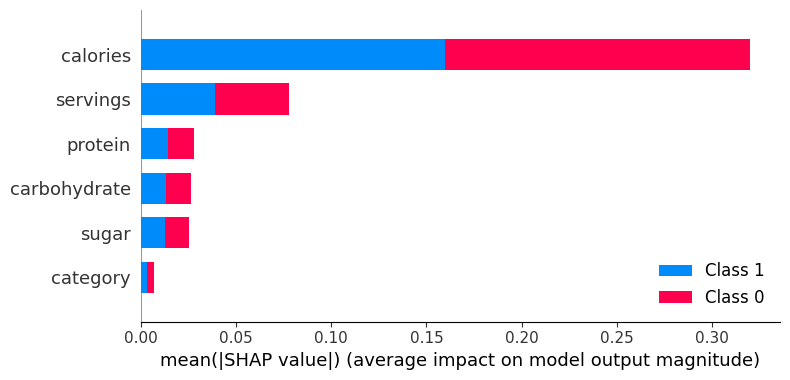

In [39]:
import shap

# Assuming grid_search_rf is your trained GridSearchCV object
best_rf_model = grid_search_rf.best_estimator_['model']

# Initialize the SHAP explainer (Tree explainer is typically used for tree-based models like RandomForest)
explainer = shap.Explainer(best_rf_model)

# You need to transform the features_test to pass through the same preprocessing as the training data
# Since the pipeline's ColumnTransformer does this, you can use it to transform your test data
transformed_features_test = grid_search_rf.best_estimator_.named_steps['col_transformer'].transform(features_test)

# Compute SHAP values
shap_values = explainer.shap_values(transformed_features_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, transformed_features_test, feature_names=nums+cats)


This chart of feature importances is surprising to me, given that our earlier heatmap seemed to indicate high correlations between certain categories and high/low traffic. There may be a link between category and calories that we did not see earlier. Let's now examine this more closely, in the context of high/low traffic.

The model also takes into account servings, protein, carbohydrate, and suagr to a lesser degree than it does calories.

Text(0.5, 1.0, 'Breaking down calorie and traffic distribution per category')

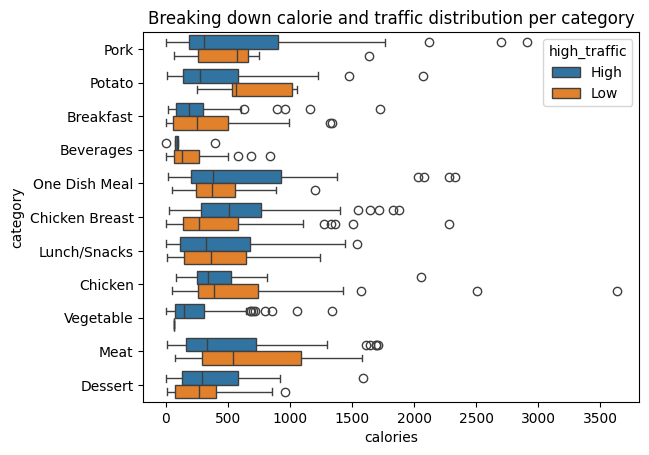

In [40]:
sns.boxplot(data=df, x='calories', y='category', hue='high_traffic')
plt.title('Breaking down calorie and traffic distribution per category')

There does appear to be a relationship between category and calories. For potatoes, beverages, and vegetables, the interquartile ranges overlap very little for high and low traffic instances of that category. I can see how the model could take both calories and category into account and look at their interaction, with the focus being on calories. I would expect to see better predictions for these categories, and other less-overlapping categories, as opposed to categories that overlap greatly. 

Precision should be monitored throughout the duration of this model's implementation. If after three months this collected data shows that the model is not or is no longer identifying high-traffic models at least 80% of the time, we should again work on this model using the newly-expanded dataset. In any case, after a few months of additional data collection, we should retrain the model to ensure up-to-date precision.

Website traffic to the rest of the website (pages beyond the homepage) should be monitored after implementation, as that is the primary gauge for whether or not a recipe is considered high-traffic. This is the key metric that should be added to the dataset along with the nutritional information/features of the new recipes.

A solid KPI, beyond basic website traffic, would be the bounce rate. This is a percentage of the number of visitors who leave the site shortly after entering. Because the company offers recipes, a visitor who is engaging with the recipe on the front page is likely to remain on the website while ingredients are prepared and the recipe is followed. A low bounce rate would indicate that a high percentage of users are staying on the site. The company has already observed that higher traffic leads to more subscriptions. The company could run statistical tests to verify this, and also to verify that bounce rate and website traffic are acting as effective KPIs, or our data science team can perform those for you after a few months of data collection. 

Monthly recurring revenue would be a good KPI to measure the impact of subscriptions on the company's finances. The company suggests that more subscriptions is better for the company, but this is vague. The monthly recurring revenue would take into account subscriptions tiers and churning by providing the total revenue gained from subscriptions each month. The company could track website traffic and bounce rate against this monthly recurring revenue. The predictive model that we have provided should increase website traffic and decrease the bounce rate by accurately predicting high-traffic recipes 80.4% of the time, therefore driving up subscription rates and monthly recurring revenue in a measurable way, and saving the company time by automating the recipe selection process. Further statistical tests could validate this ultimate effect on revenue.

Looking at the cross-validated results for more direct comparison between the two models I tried, the random forest had a slightly lower precision than the logistic regression, but a fairly better recall. This means that the model I chose is slightly less accurate than the other at predicting high-traffic recipes, but fairly better at finding high-traffic recipes, while still meeting the given requirements for precision. Because the chosen model can accurately identify high-traffic recipes 80% of the time, website traffic should increase, and that would have been true for either model, though we chose to only fully test the model with better cross-validation results to ensure minimum bias in the final result.

# Final Recommendations

The business should deploy this predictive model to automate the high-traffic recipe selection process. More frequently displaying high-traffic recipes on your homepage will increase website traffic and should decrease bounce rate, the combination of which should lead to more new subcriptions and therefore a higher monthly recurring revenue. The model will select these recipes automatically, but it may be helpful to know that, generally speaking: pork, potato, and vegetable dishes tend to generate high traffic, while beverages and breakfast tend to generate low traffic. I would suggest that your team runs statistical tests in about 3 months to ensure the ultimate positive correlation between high-traffic recipes and monthly recurring revenue, or our team would be happy to evaluate that data for you to ensure continued quality results.

# Model Delivery

Here I will save the final model, trained on the whole dataset, that may be used to predict high-traffic recipes given the same set of features.

In [41]:
grid_search_rf.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 4,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5,
 'model__n_estimators': 80}

In [42]:
import joblib

final_model = RandomForestClassifier(random_state=0, class_weight='balanced', criterion='gini', max_depth=4, min_samples_leaf=1, min_samples_split=5, n_estimators=80)

col_transformer = ColumnTransformer(transformers=[
    ('ordinal encoder', OrdinalEncoder(), cats),
    ('scaler', StandardScaler(), nums)
])

rf_pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('model', final_model)
])

rf_pipeline.fit(features, target)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('ordinal encoder',
                                                  OrdinalEncoder(),
                                                  ['category']),
                                                 ('scaler', StandardScaler(),
                                                  ['calories', 'carbohydrate',
                                                   'sugar', 'protein',
                                                   'servings'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=4,
                                        min_samples_split=5, n_estimators=80,
                                        random_state=0))])

In [43]:
joblib.dump(rf_pipeline, 'recipe_predictor.pkl')

['recipe_predictor.pkl']

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation